<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Updated-version-of-greengenes" data-toc-modified-id="Updated-version-of-greengenes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Updated version of greengenes</a></span></li><li><span><a href="#Process-all-16S-and-SMS-datasets}" data-toc-modified-id="Process-all-16S-and-SMS-datasets}-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Process all 16S and SMS datasets}</a></span><ul class="toc-item"><li><span><a href="#Setup-cross-validation" data-toc-modified-id="Setup-cross-validation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Setup cross validation</a></span></li></ul></li></ul></div>

This notebook is focused on obtaining a genus-level table for 16S and SMS for Dan et al.

In [1]:
import biom
from biom.util import biom_open
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr

%matplotlib inline

# Updated version of greengenes

In [2]:
#taxonomy = pd.read_table('~/ceph/gg2/2022.7/2022.7.taxonomy.id.tsv.qza-dir/taxonomy.tsv', index_col=0)
taxonomy = pd.read_table('~/ceph/gg2/2022.8/2022.8.taxonomy.id.tsv', index_col=0)


cols = ['k', 'p', 'c', 'o', 'f', 'g', 's']

def taxa_string(x):
    
    s = ''
    for i, n in enumerate(x):
        if np.isnan(x[i]):
            s+= f'{cols[i]}; '
        else:
            s += f'{cols[i]}__{x[i]} ;'
    return s

In [3]:
cols = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

def taxa_f(x):
    tabs = x.split(';')
    
    def f(y):
        if len(y.split('__')[1]) == '':
            return np.nan
        return y.split('__')[1]
        
    return list(map(f, tabs))
    
taxa_df = taxonomy.Taxon.apply(taxa_f)
taxa_df_2 = pd.DataFrame(list(taxa_df.values), index=taxa_df.index, columns=cols)
taxa_df_2 = taxa_df_2.replace('', np.nan)

In [4]:
taxonomy_wol = pd.read_table('~/ceph/wol2/wol2/taxonomy/lineages.txt', index_col=0, header=None)
# taxonomy_wol = pd.read_table('~/databases/wol/taxonomy/lineages.txt', index_col=0, header=None)

In [5]:
wol_df = taxonomy_wol[1].apply(taxa_f)
wol_df_2 = pd.DataFrame(list(wol_df.values), index=wol_df.index, columns=cols)
wol_df_2 = wol_df_2.replace('', np.nan)

In [6]:
DIR_SMS = '../sfari/data/sra_shotgun/Dan2020'
DIR_16S = '../sfari/data/sra/Dan2020'
metadata_SMS = pd.read_table(
    f'{DIR_SMS}/sample_metadata_JM.txt', index_col=0
)

metadata_16S = pd.read_table(
    f'{DIR_16S}/sample_metadata_JM.txt', index_col=0
)

missing = metadata_16S.loc['SRR9666805', 'original_sample_id'] # missing for god knows why
metadata_SMS = metadata_SMS.reset_index().set_index('Subject_name')
metadata_16S = metadata_16S.reset_index().set_index('original_sample_id')
common_ids = list(set(metadata_SMS.index) & set(metadata_16S.index) - {missing})
metadata_16S = metadata_16S.loc[common_ids]
metadata_SMS = metadata_SMS.loc[common_ids]

metadata_16S = metadata_16S.reset_index().set_index('sampleid')
metadata_SMS = metadata_SMS.reset_index().set_index('Run')

In [7]:
def collapse_genus(dat, taxa):
    dat['IDX'] = taxa['genus']
    genera = dat.groupby('genus').sum()
    return genera

# load and process SMS
table_SMS = biom.load_table(
    f'{DIR_SMS}/bioms/ogus2-corrected.biom'
)
taxa_SMS = taxonomy_wol.loc[table_SMS.ids(axis='observation')]
idx = wol_df_2.apply(lambda x: ';'.join(map(str, x[:-1])), axis=1)
tab = table_SMS.to_dataframe()
tab['genus'] = wol_df_2['genus']
genera_SMS = tab.groupby('genus').sum()

# load and process 16S
table_16S = biom.load_table(
    f'{DIR_16S}/deblur/vsearch/clustered_table/feature-table.biom'
)
taxa_16S = taxa_df_2.loc[table_16S.ids(axis='observation')]

idx = taxa_16S.apply(lambda x: ';'.join(map(str, x[:-1])), axis=1)
tab = table_16S.to_dataframe()
tab['genus'] = taxa_16S['genus']
genera_16S = tab.groupby('genus').sum()
#genera_16S = collapse_genus(table_16S.to_dataframe(), taxa_16S)

# save to biom table, since this takes forever!
biom_16S = biom.Table(genera_16S.values, genera_16S.index, genera_16S.columns)
biom_SMS = biom.Table(genera_SMS.values, genera_SMS.index, genera_SMS.columns)

with biom_open(f'{DIR_16S}/deblur/vsearch/clustered_table/genus-table.biom', 'w') as f:
    biom_16S.to_hdf5(f, 'Jamie')

DIR = '../sfari/data/sra_shotgun/Dan2020'
with biom_open(f'{DIR_SMS}/bioms/genus-table.biom', 'w') as f:
    biom_SMS.to_hdf5(f, 'Jamie')

In [8]:
metadata_SMS['Sample ID']

Run
SRR7057664     B99
SRR7057658     B14
SRR7057659     B28
SRR7057634     A73
SRR7057656      B8
SRR7057674    B142
SRR7057630     A67
SRR7057646    A144
SRR7057666    B106
SRR7057621      A5
SRR7057628     A54
SRR7057635     A76
SRR7057647    A149
SRR7057669    B115
SRR7057629     A59
SRR7057636     A78
SRR7057673    B141
SRR7057671    B127
SRR7057632     A69
SRR7057633     A71
SRR7057663     B94
SRR7057624     A31
SRR7057648    A164
SRR7057623      A9
SRR7057678    B158
SRR7057649    A165
SRR7057645    A142
SRR7057627     A53
SRR7057654      B6
SRR7057625     A51
SRR7057675    B143
SRR7057631     A68
SRR7057642    A113
SRR7057650      B1
SRR7057677    B156
SRR7057661     B36
SRR7057641    A109
SRR7057640    A101
SRR7057626     A52
SRR7057672    B132
SRR7057662     B37
SRR7057668    B114
SRR7057639     A93
SRR7057643    A114
SRR7057637     A87
SRR7057679    B164
SRR7057667    B111
SRR7057622      A6
SRR7057670    B120
SRR7057660     B29
SRR7057651      B2
SRR7057676    B152
SRR70576

In [9]:
metadata_16S.columns

Index(['original_sample_id', 'Stage', 'Gender', 'Age', '16S RNA sequencing',
       'Metagenomic sequencing', 'Metabonomic analysis', 'Constipation',
       'Gender_Cat', 'Age_Cat', 'matching_id', 'ReleaseDate', 'LoadDate',
       'spots', 'bases', 'spots_with_mates', 'avgLength', 'size_MB',
       'AssemblyName', 'download_path', 'Experiment', 'LibraryName',
       'LibraryStrategy', 'LibrarySelection', 'LibrarySource', 'LibraryLayout',
       'InsertSize', 'InsertDev', 'Platform', 'Model', 'SRAStudy',
       'BioProject', 'Study_Pubmed_id', 'ProjectID', 'Sample', 'BioSample',
       'SampleType', 'TaxID', 'ScientificName', 'SampleName', 'g1k_pop_code',
       'source', 'g1k_analysis_group', 'Subject_ID', 'Sex', 'Disease', 'Tumor',
       'Affection_Status', 'Analyte_Type', 'Histological_Type', 'Body_Site',
       'CenterName', 'Submission', 'dbgap_study_accession', 'Consent',
       'RunHash', 'ReadHash', 'Reads number', 'Base number', 'Mean length',
       'Min length', 'Max length'

Match metadata to biom tables

In [10]:
genera_SMS = genera_SMS.loc[:, metadata_SMS.index]
genera_16S = genera_16S.loc[:, metadata_16S.index]

common_taxa = list(set(genera_SMS.index) & set(genera_16S.index))

genera_SMS_ = genera_SMS.loc[common_taxa]
genera_16S_ = genera_16S.loc[common_taxa]

print(f'Common taxa {len(common_taxa)}')

Common taxa 298


In [11]:
genera_SMS_ = genera_SMS_.apply(lambda x: x / x.sum())
genera_16S_ = genera_16S_.apply(lambda x: x / x.sum())

Text(0, 0.5, 'SMS')

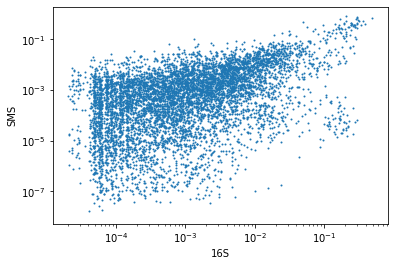

In [12]:
plt.scatter(genera_16S_.values.ravel(), genera_SMS_.values.ravel(), s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('16S')
plt.ylabel('SMS')

Text(0.5, 1.0, 'Abundances')

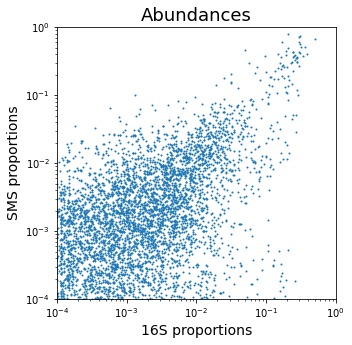

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(genera_16S_.values.ravel(), genera_SMS_.values.ravel(), s=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-4, 1])
ax.set_ylim([1e-4, 1])
ax.set_xlabel('16S proportions', fontsize=14)
ax.set_ylabel('SMS proportions', fontsize=14)
ax.set_title('Abundances', fontsize=18)
#plt.plot([1e-7, 1], [1e-7, 1], c='r')

In [14]:
pearsonr(genera_16S_.values.ravel(), genera_SMS_.values.ravel())

(0.6355494371717114, 0.0)

In [15]:
spearmanr(genera_16S_.values.ravel(), genera_SMS_.values.ravel())

SpearmanrResult(correlation=0.4949458659413131, pvalue=0.0)

In [16]:
rs, ps = [], []
for i in range(genera_16S_.shape[1]):
    #print(pearsonr(genera_16S_.values[:, i], genera_SMS_.values[:, i]))
    r, p = pearsonr(genera_16S_.values[:, i], genera_SMS_.values[:, i])
    rs.append(r)
    ps.append(p)

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

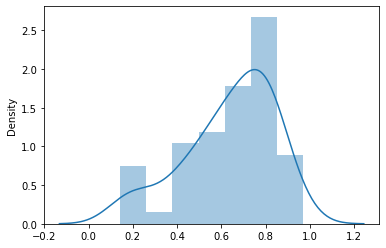

In [17]:
sns.distplot(rs)

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

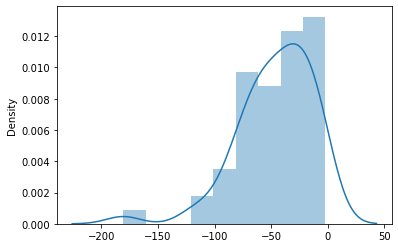

In [18]:
sns.distplot(np.log10(ps))

Save extra copy of genus tables

In [19]:
metadata_SMS = (metadata_SMS
                .groupby('Match_IDs')
                .filter(lambda x: len(x) == 2))

metadata_16S = (metadata_16S
 .reset_index()
 .set_index('original_sample_id')
 .loc[metadata_SMS['Subject_name'].values]
 .reset_index()
 .set_index('sampleid'))

metadata_16S['Match_IDs'] = metadata_SMS['Match_IDs']

In [20]:
genera_16S = genera_16S[metadata_16S.index]
genera_SMS = genera_SMS[metadata_SMS.index]

# save to biom table, since this takes forever!
biom_16S = biom.Table(genera_16S.values, genera_16S.index, genera_16S.columns)
biom_SMS = biom.Table(genera_SMS.values, genera_SMS.index, genera_SMS.columns)

with biom_open(f'{DIR_16S}/deblur/vsearch/clustered_table/genus-table-matched.biom', 'w') as f:
    biom_16S.to_hdf5(f, 'Jamie')

metadata_16S.to_csv(f'{DIR_16S}/matched_metadata_v2.txt', sep='\t')    
    
DIR = '../sfari/data/sra_shotgun/Dan2020'
with biom_open(f'{DIR_SMS}/bioms/genus-table-matched.biom', 'w') as f:
    biom_SMS.to_hdf5(f, 'Jamie')
    
metadata_SMS.to_csv(f'{DIR_SMS}/matched_metadata_v2.txt', sep='\t')

# Process all 16S and SMS datasets}

In [21]:
#amp_table = biom.load_table('../sfari/data/sra/Kang2017/deblur/vsearch/clustered_table/feature-table.biom')
amp_table = biom.load_table('../sfari/data/sra/Combined/deblur/vsearch/clustered_table/feature-table.biom')
sms_table = biom.load_table('../sfari/data/sra_shotgun/Combined/ogus_table-v2.biom')

amp_metadata = pd.read_table('../sfari/data/sra/Kang2017/combined_sample_metadata_0.txt', index_col=0)
sms_metadata = pd.read_table('../sfari/data/sra_shotgun/Combined/sample_metadata.txt', index_col=0)
metadata = pd.concat((amp_metadata, sms_metadata), axis=0)
metadata['Variable_Region'] = metadata['Variable_Region'].fillna('SMS')

In [22]:
# collapse SMS
taxa_SMS = taxonomy_wol.loc[sms_table.ids(axis='observation')]
idx = taxa_SMS.apply(lambda x: ';'.join(map(str, x[:-1])), axis=1)
tab = sms_table.to_dataframe()
tab['genus'] = taxa_SMS['genus']
genera_SMS = tab.groupby('genus').sum()
# collapse 16S
taxa_16S = taxa_df_2.loc[amp_table.ids(axis='observation')]
idx = taxa_16S.apply(lambda x: ';'.join(map(str, x[:-1])), axis=1)
tab = amp_table.to_dataframe()
tab['genus'] = taxa_16S['genus']
genera_16S = tab.groupby('genus').sum()

biom_16S = biom.Table(genera_16S.values, genera_16S.index, genera_16S.columns)
biom_SMS = biom.Table(genera_SMS.values, genera_SMS.index, genera_SMS.columns)
biom_all = biom_16S.merge(biom_SMS)

KeyError: 'genus'

In [ ]:
filter_f = lambda v, i, m: i in set(metadata.index)
biom_all.filter(filter_f)
metadata = metadata.loc[biom_all.ids()]

In [ ]:
DIR = '../sfari/data/microbiome_combined'
with biom_open(f'{DIR}/genus-table.biom', 'w') as f:
    biom_all.to_hdf5(f, 'Jamie')
    
metadata.to_csv(f'{DIR}/sample_metadata.txt', sep='\t')

## Setup cross validation 

Leave-one-study-out in addition to 10% of other matchings, and store all of the cross-validation results in 1 file

In [ ]:
#keys = list(map(lambda x: x[0], list(metadata.groupby(['Variable_Region', 'Cohort']))))
core = {'Dan2020'}
cohorts = set(metadata['Cohort'].unique())
cv_metadata = metadata.copy()
for i, c in enumerate(list(cohorts - core)):
    train_cohort = cohorts - {c}
    matches = np.random.permutation(cv_metadata['Match_IDs'].unique())
    train_matches = matches[len(matches) // 10:]
    cohort_f = lambda x: x['Cohort'] in train_cohort
    match_f = lambda x: x['Match_IDs'] in train_matches
    
    def train_f(x):
        if cohort_f(x) and match_f(x):
            return 'Train'
        return 'Test'
        
    cv_metadata[f'fold_{i}'] = cv_metadata.apply(train_f, axis=1)

In [ ]:
cv_metadata.to_csv(f'{DIR}/sample_metadata_cv.txt', sep='\t')

In [ ]:
cv_metadata['fold_0'].value_counts()